In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel

In [2]:
# Import the fourier method
from scripts.fouriermethod import SolverChebyshev

### Initialisation
The condition are as follows:
$a=1$ ,
$p=1$ ,
the constraint is $0 <x_i <1$ .

In [210]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    results_folder = '../outputs/results/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=100,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=True,
    save_model=True,
    save_hist=True
    )


### Dataset

In [211]:
train_set, val_set = model.CreateDataSet()

# Train the model

In [212]:
pretrained = False
if pretrained:
    model.model.load_state_dict(torch.load(model.model_folder+model.model_id+'weights.pt'))
else:
    model.train(train_set,val_set)

epoch :  0  -----  training :  0.0338    validation :  0.0285
epoch :  1  -----  training :  0.0323    validation :  0.0272
epoch :  2  -----  training :  0.0309    validation :  0.0259
epoch :  3  -----  training :  0.0296    validation :  0.0248
epoch :  4  -----  training :  0.0284    validation :  0.0237
epoch :  5  -----  training :  0.0273    validation :  0.0228
epoch :  6  -----  training :  0.0264    validation :  0.0219
epoch :  7  -----  training :  0.0255    validation :  0.0212
epoch :  8  -----  training :  0.0247    validation :  0.0205
epoch :  9  -----  training :  0.0239    validation :  0.0198
epoch : 10  -----  training :  0.0233    validation :  0.0193
epoch : 11  -----  training :  0.0227    validation :  0.0188
epoch : 12  -----  training :  0.0222    validation :  0.0184
epoch : 13  -----  training :  0.0217    validation :  0.0180
epoch : 14  -----  training :  0.0213    validation :  0.0177
epoch : 15  -----  training :  0.0209    validation :  0.0174
epoch : 

# Naive reconstruction

In [213]:
data_set = next(iter(val_set))      # get the minibatch
y, x = data_set[0], data_set[1]            
x_true  = np.array(x)[0,0]
x_bias  = np.array(y)[0,0]

x_true_elt = model.physics.BasisChangeInv(x_true)

In [214]:
x_adjoint_elt = model.physics.BasisChangeInv( model.physics.ComputeAdjoint(model.physics.Compute(model.physics.BasisChangeInv(x_true))))
x_bias_elt = model.physics.BasisChangeInv(x_bias)
# plt.plot(x_bias_elt, label='noisy adjoint')
# plt.plot(x_adjoint_elt,label='true adjoint')
# plt.title('Adjoint signals')
# plt.legend()
# plt.show()

In [215]:
x_recover_clean = model.physics.inv.dot(model.physics.BasisChange(x_adjoint_elt) )
x_recover_noisy = model.physics.inv.dot(x_bias)

x_recover_clean_elt = model.physics.BasisChangeInv(x_recover_clean)
x_recover_noisy_elt = model.physics.BasisChangeInv(x_recover_noisy)

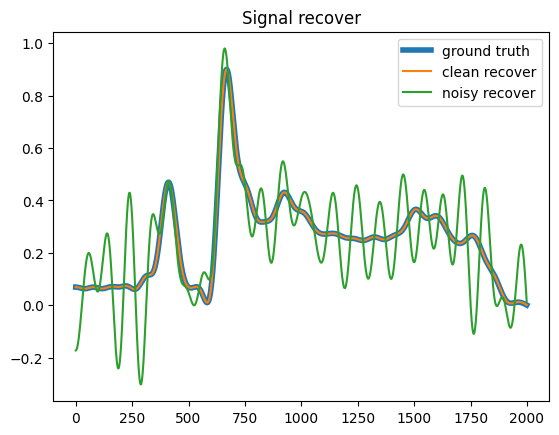

Relative error: 0.1919114893990146


In [216]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_recover_clean_elt, label='clean recover')
plt.plot(x_recover_noisy_elt,label='noisy recover')
plt.title('Signal recover')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_recover_noisy_elt)**2)/np.sum(x_true_elt**2)))

# Tikhonov regularisation

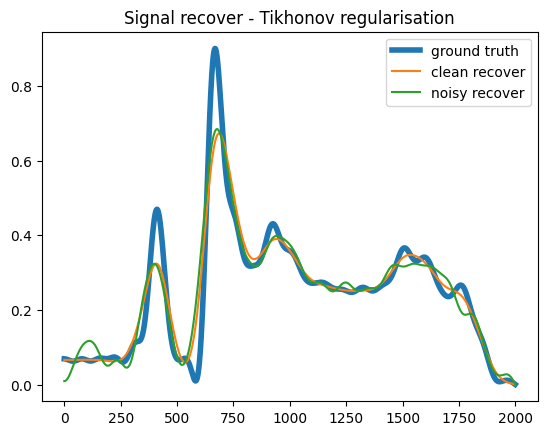

Relative error: 0.03540086565637166


In [225]:
treshold = 1e-7
eig_vals = model.physics.eigw.copy()
tikho_inv = np.diag(eig_vals /(eig_vals**2 + treshold))

x_tikho_clean = tikho_inv.dot(model.physics.BasisChange(x_adjoint_elt) )
x_tikho_noisy = tikho_inv.dot(x_bias)

x_tikho_clean_elt = model.physics.BasisChangeInv(x_tikho_clean)
x_tikho_noisy_elt = model.physics.BasisChangeInv(x_tikho_noisy)


plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_tikho_clean_elt, label='clean recover')
plt.plot(x_tikho_noisy_elt,label='noisy recover')
plt.title('Signal recover - Tikhonov regularisation')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_tikho_noisy_elt)**2)/np.sum(x_true_elt**2)))

# Model reconstruction

In [226]:
loss, signals = model.test(val_set,plot_opt=False)

Saving predictions...
Erreur de sortie :  0.015216167084872723
Erreur initiale :  0.12672553956508636


In [227]:
model_predictions_elt = np.load(model.results_folder+model.model_id+'predictions.npy')

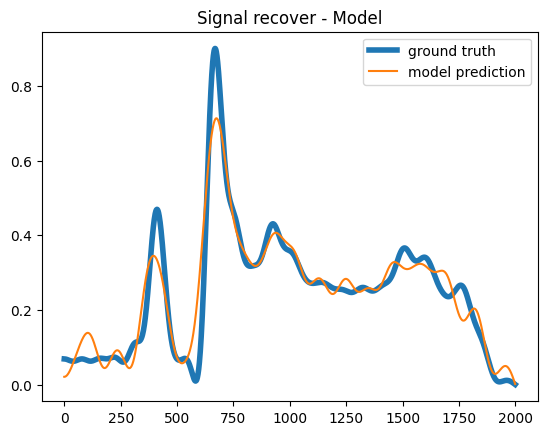

Relative error: 0.03158821150566795


In [228]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(model_predictions_elt[0,0], label='model prediction')
plt.title('Signal recover - Model')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-model_predictions_elt[0,0])**2)/np.sum(x_true_elt**2)))

# Filter the recovered signal: Fourier method

In [229]:
f_cut = 15
filter = np.zeros((50,50))
np.fill_diagonal(filter[:f_cut,:f_cut], 1)


In [230]:
x_recover_filtered = filter.dot(x_recover_noisy)
x_recover_filtered_elt = model.physics.BasisChangeInv(x_recover_filtered)


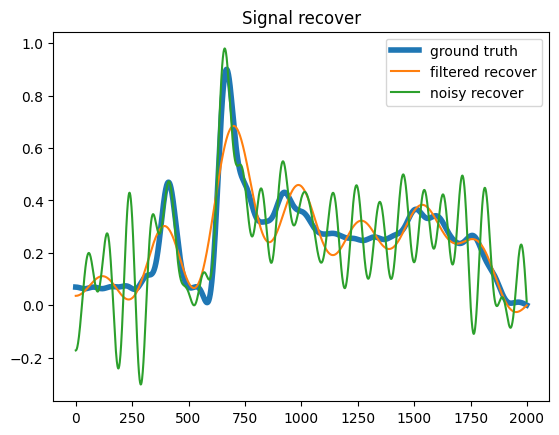

Relative error: 0.056351849853523615


In [231]:
plt.plot(x_true_elt, label='ground truth', linewidth=4)
plt.plot(x_recover_filtered_elt, label='filtered recover')
plt.plot(x_recover_noisy_elt,label='noisy recover')
plt.title('Signal recover')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_recover_filtered_elt)**2)/np.sum(x_true_elt**2)))

## Quick test

In [235]:
fourier_filter = SolverChebyshev(model.physics.nx,model.physics.m,model.physics.a,model.physics.p)

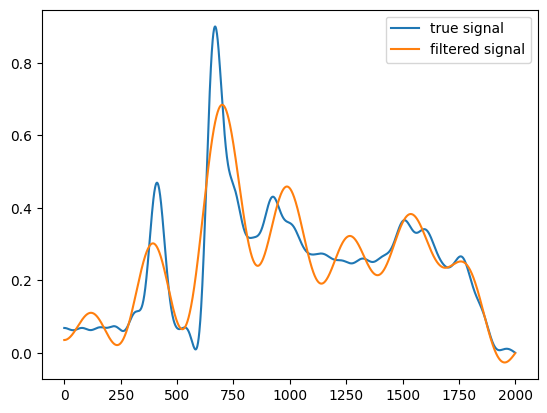

Example error: 0.056351849853523615
Average error: 0.023298410333060734


In [236]:
err, err_list = fourier_filter.Fourier_filter(val_set,15/50, display=True, idx=0)
print('Example error: {}'.format(err_list[0]))
print('Average error: {}'.format(err))

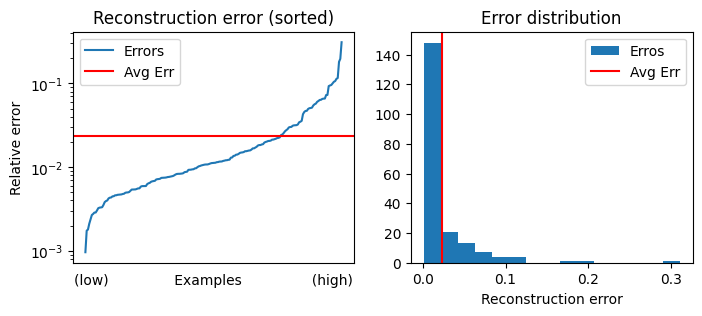

In [237]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(np.sort(np.array(err_list)), label='Errors')
ax[0].set_yscale('log')
ax[0].axhline(y = err, color = 'r', label = 'Avg Err')
ax[0].set_title('Reconstruction error (sorted)')
ax[0].set_ylabel('Relative error')
ax[0].set_xlabel('(low)               Examples                (high)')
ax[0].legend()
ax[0].set_xticks([])

ax[1].hist(np.array(err_list), 15, label='Erros')
ax[1].axvline(x = err, color = 'r', label = 'Avg Err')
ax[1].legend()
ax[1].set_title('Error distribution')
ax[1].set_xlabel('Reconstruction error')
plt.show()

# LOWESS filter

In [238]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

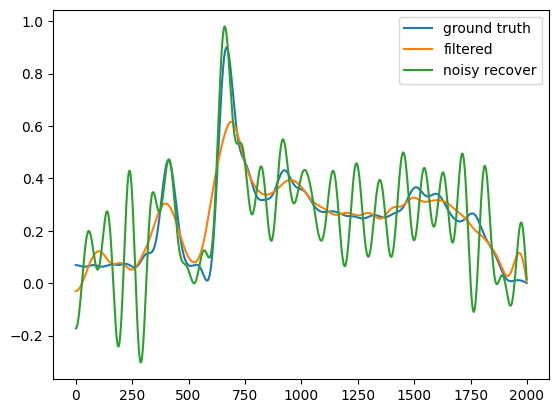

Relative error: 0.05101515623080658


In [239]:
filtered = lowess(x_recover_noisy_elt, np.linspace(0,2000-1,2000),
    frac=200/2000,
    it=1,
    delta=50)
x_recovered_lowess = model.physics.BasisChangeInv(model.physics.BasisChange(filtered[:, 1]))
plt.plot(x_true_elt,label='ground truth')
plt.plot(filtered[:, 0], x_recovered_lowess,label='filtered')
plt.plot(x_recover_noisy_elt,label='noisy recover')
plt.legend()
plt.show()

print('Relative error: {}'.format(np.sum((x_true_elt-x_recovered_lowess)**2)/np.sum(x_true_elt**2)))